# Culture Data Competition
[개요]

# 0. Setting

## Library Call

In [358]:
# Library Call
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import time
import datetime as dt
# !pip install folium
import folium

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

## Visualization Font Setting

In [212]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'Malgun Gothic'

## User Function Definition

In [213]:
# Merge Same DataFrame Format
def Multiple_Data_Load(flist):
    df = []
    for file in flist:
        ele = pd.read_csv(file)
        df.append(ele)
    return pd.concat(df)

# Return Col names by Metadata Seat
def return_col(meta):
    df = pd.read_excel('Metadata/'+meta,index_col='순서')
    col = df['컬럼한글명'].values
    return col

# Weekday List Definition
weekday_label = np.array(['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'])

# return MissingValue Existence
def MissingValue_Existence(df):
    value = df.isna().sum().sum()
    return f"MissinValue's counts : {value}"

# 1. Culture Data EDA & Visualization

## 1. 문화누리 키워드 검색량 데이터
[출처] : 데이터마케팅코리아   

[Data Description]
- '문화누리카드', '문화누리' 키워드에 대한 모바일검색량, PC검색량 등이 포함된 일별 검색량 데이터   
- 데이터 수집 기간 : 2021-11-01 ~ 2022-03-31 (5 months, by a day)

[Applications]
- 문화누리카드, 문화누리 대한 소비자의 일별 검색 트렌드 분석   

[Insight Goal]
- 문화누리카드의 일별 검색 트렌드를 분석함으로써 최근 N년 간 문화누리카드의 관심도 변화와 인식 등에 대해 분석하고자함. 또한, 모바일 매채별, 날짜별로 검색량을 그룹화하여 특정 카테고리에 따라 어떠한 양상을 보이는지 확인하고자함. 이를 통해, 문화누리 카드의 현주소를 파악하고, 트렌드 추세에 맞는 아이디어를 기획하고자 함.

### Data Load

In [194]:
# Data Load
keyword_flist = sorted(glob.glob('data/DM_CLTUR_KWRD_SCCNT_RESULT*.csv'))
keyword_df = Multiple_Data_Load(keyword_flist)
keyword_df.columns=return_col('문화누리 키워드 검색량 데이터_컬럼정의서.xls')
print('keyword_df.shape :',keyword_df.shape)
keyword_df.head()

keyword_df.shape : (304, 6)


,일련,검색어,Mobile 검색량,PC 검색량,검색량 합계,검색량 날짜
0,4258,문화누리,254,207,461,2021-11-01
1,4259,문화누리,300,190,490,2021-11-02
2,4260,문화누리,263,169,432,2021-11-03
3,4261,문화누리,224,198,422,2021-11-04
4,4262,문화누리,263,192,455,2021-11-05


### Data EDA & Preprocessing

In [195]:
# Data Information
keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 61
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   일련          304 non-null    int64 
 1   검색어         304 non-null    object
 2   Mobile 검색량  304 non-null    int64 
 3   PC 검색량      304 non-null    int64 
 4   검색량 합계      304 non-null    int64 
 5   검색량 날짜      304 non-null    object
dtypes: int64(4), object(2)
memory usage: 16.6+ KB


In [196]:
# Check MissingValue Existence
MissingValue_Existence(keyword_df)

"MissinValue's counts : 0"

In [197]:
# Feature Selection
keyword_df.drop('일련',inplace=True, axis=1)

In [198]:
# Drop Duplicates
keyword_df.drop_duplicates(inplace=True)

In [199]:
# Datetime 파생변수 생성
keyword_df['검색량 날짜'] = pd.to_datetime(keyword_df['검색량 날짜'])
keyword_df.sort_values('검색량 날짜',inplace=True)

keyword_df['검색월'] = keyword_df['검색량 날짜'].dt.month
keyword_df['검색일'] = keyword_df['검색량 날짜'].dt.day
keyword_df['검색년도'] = keyword_df['검색량 날짜'].dt.year
keyword_df['검색요일'] = weekday_label[keyword_df['검색량 날짜'].dt.weekday.values]

In [200]:
# ReIndexing
keyword_df.index = keyword_df['검색량 날짜']
keyword_df.drop('검색량 날짜', inplace=True, axis=1)
keyword_df.index.name = 'date'

In [202]:
keyword_df.head(4)

,검색어,Mobile 검색량,PC 검색량,검색량 합계,검색월,검색일,검색년도,검색요일
date,,,,,,,,
2021-11-01,문화누리,254,207,461,11,1,2021,월요일
2021-11-01,문화누리카드,4307,1560,5867,11,1,2021,월요일
2021-11-02,문화누리카드,3830,1335,5165,11,2,2021,화요일
2021-11-02,문화누리,300,190,490,11,2,2021,화요일


In [203]:
# 검색어 비율
keyword_df['검색어'].value_counts(normalize=True)

문화누리      0.5
문화누리카드    0.5
Name: 검색어, dtype: float64

In [206]:
# Keyword에 따라 데이터 분리
key_a = keyword_df[keyword_df['검색어'] == '문화누리']
key_b = keyword_df[keyword_df['검색어'] == '문화누리카드']

print('key_a : 문화누리 :',key_a.shape)
print('key_b : 문화누리카드 :',key_b.shape)

key_a : 문화누리 : (151, 8)
key_b : 문화누리카드 : (151, 8)


In [207]:
# 문화누리 관련 키워드 총합 데이터프레임
key_total = key_a[['Mobile 검색량','PC 검색량','검색량 합계']] + key_b[['Mobile 검색량','PC 검색량','검색량 합계']]
key_total = pd.concat([key_total, key_a.iloc[:,4:]], axis=1)
print('key_total :',key_total.shape)
key_total.head()

key_total : (151, 7)


,Mobile 검색량,PC 검색량,검색량 합계,검색월,검색일,검색년도,검색요일
date,,,,,,,
2021-11-01,4561,1767,6328,11,1,2021,월요일
2021-11-02,4130,1525,5655,11,2,2021,화요일
2021-11-03,4324,1528,5852,11,3,2021,수요일
2021-11-04,4247,1587,5834,11,4,2021,목요일
2021-11-05,3987,1356,5343,11,5,2021,금요일


### Insight Inference & Visualize

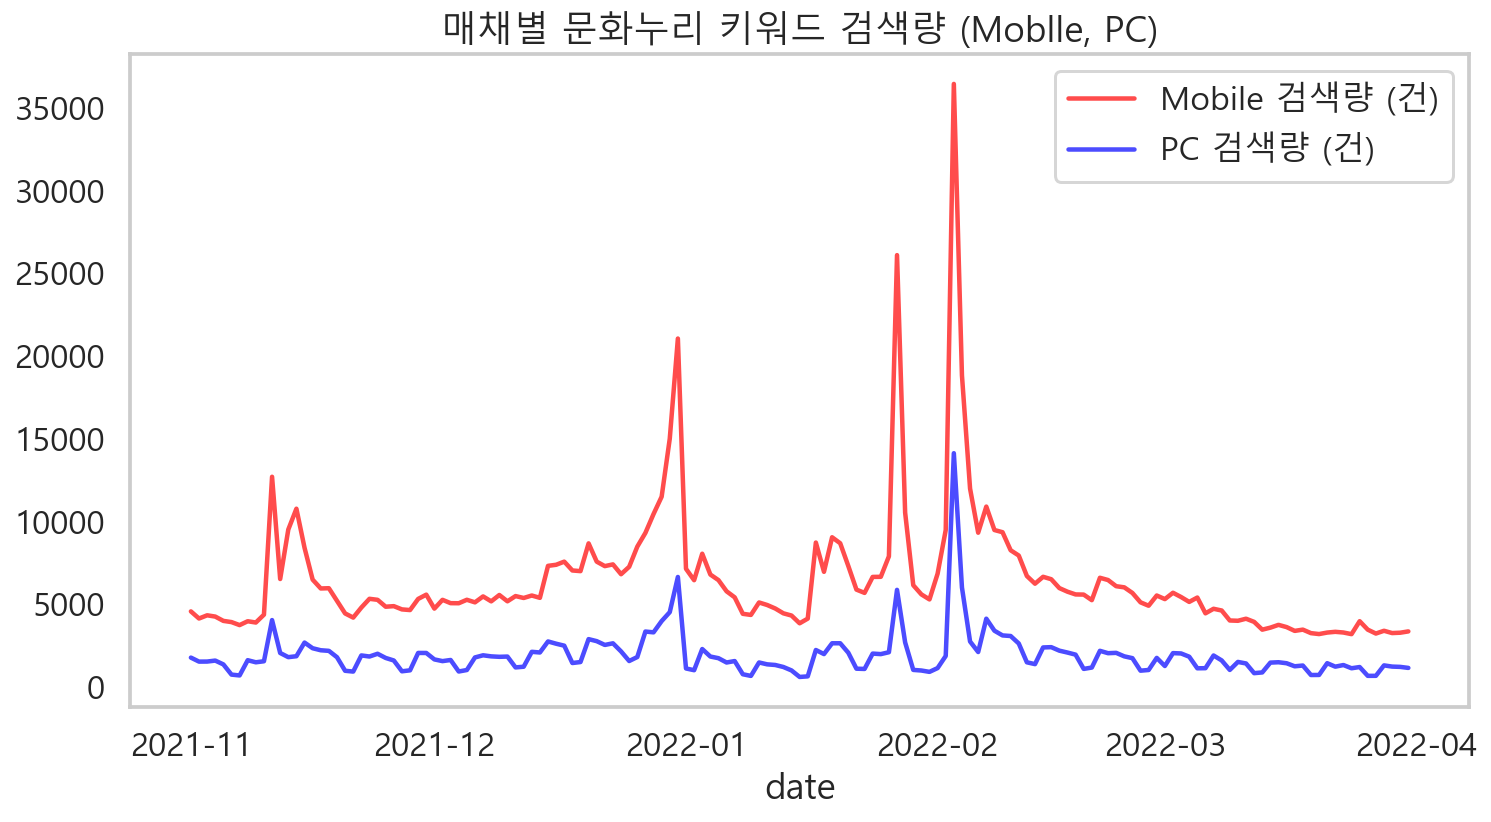

In [324]:
plt.figure(figsize=(12,6))
sns.lineplot(x = key_total.index, y = key_total['Mobile 검색량'], label='Mobile 검색량 (건)', color='r', alpha=0.7)
sns.lineplot(x = key_total.index, y = key_total['PC 검색량'], label='PC 검색량 (건)', color='b', alpha=0.7)
plt.title('매채별 문화누리 키워드 검색량 (Moblle, PC)')
plt.ylabel('')
plt.legend(loc='best')
plt.grid(False)
plt.show()

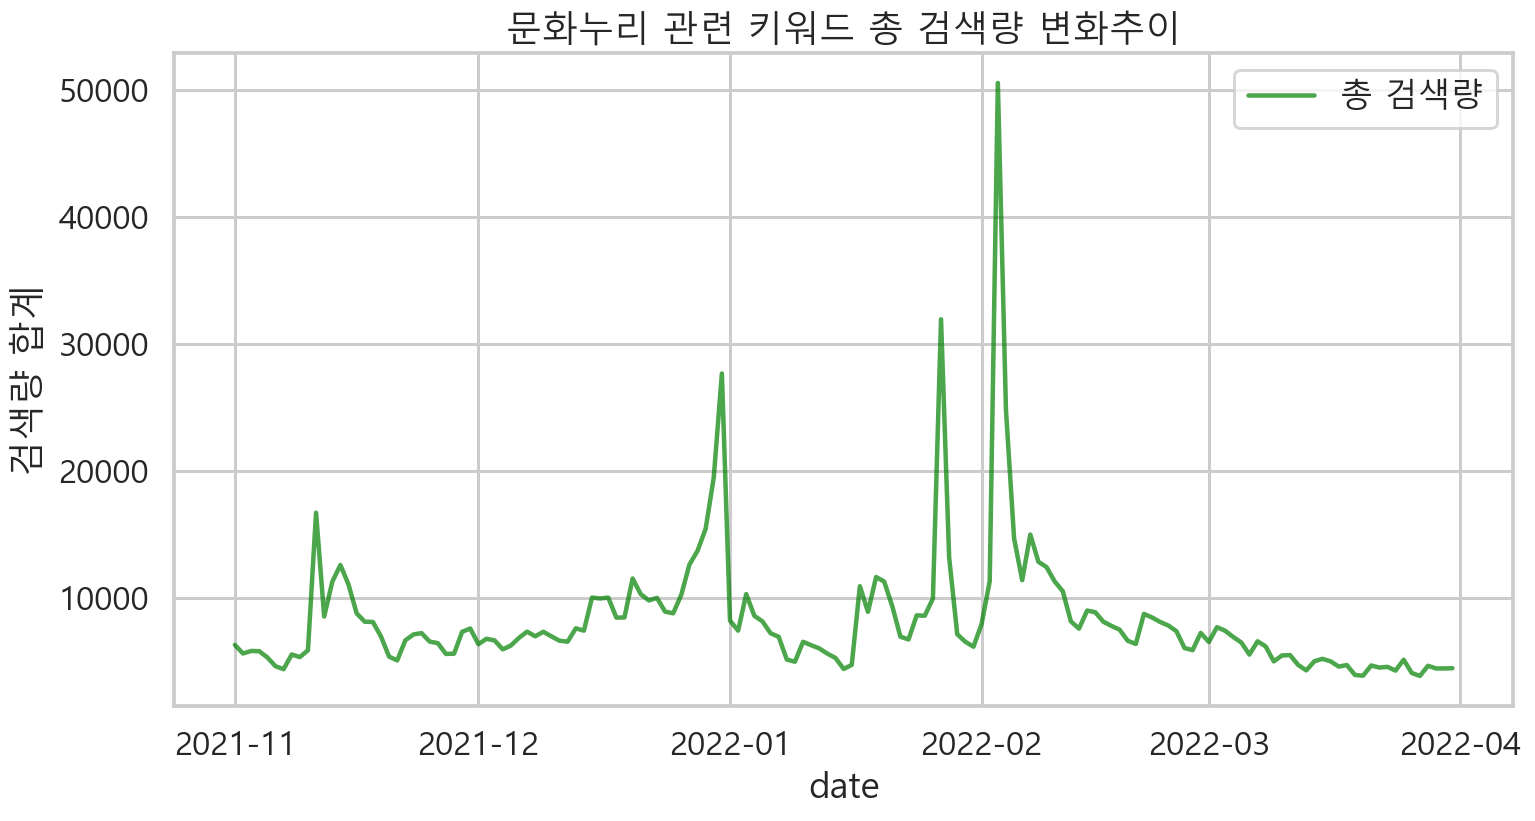

In [220]:
plt.figure(figsize=(12,6))
sns.lineplot(x = key_total.index, y = key_total['검색량 합계'], label='총 검색량', color='g', alpha=0.7)
plt.title('문화누리 관련 키워드 총 검색량 변화추이')
plt.legend(loc='best')
plt.show()

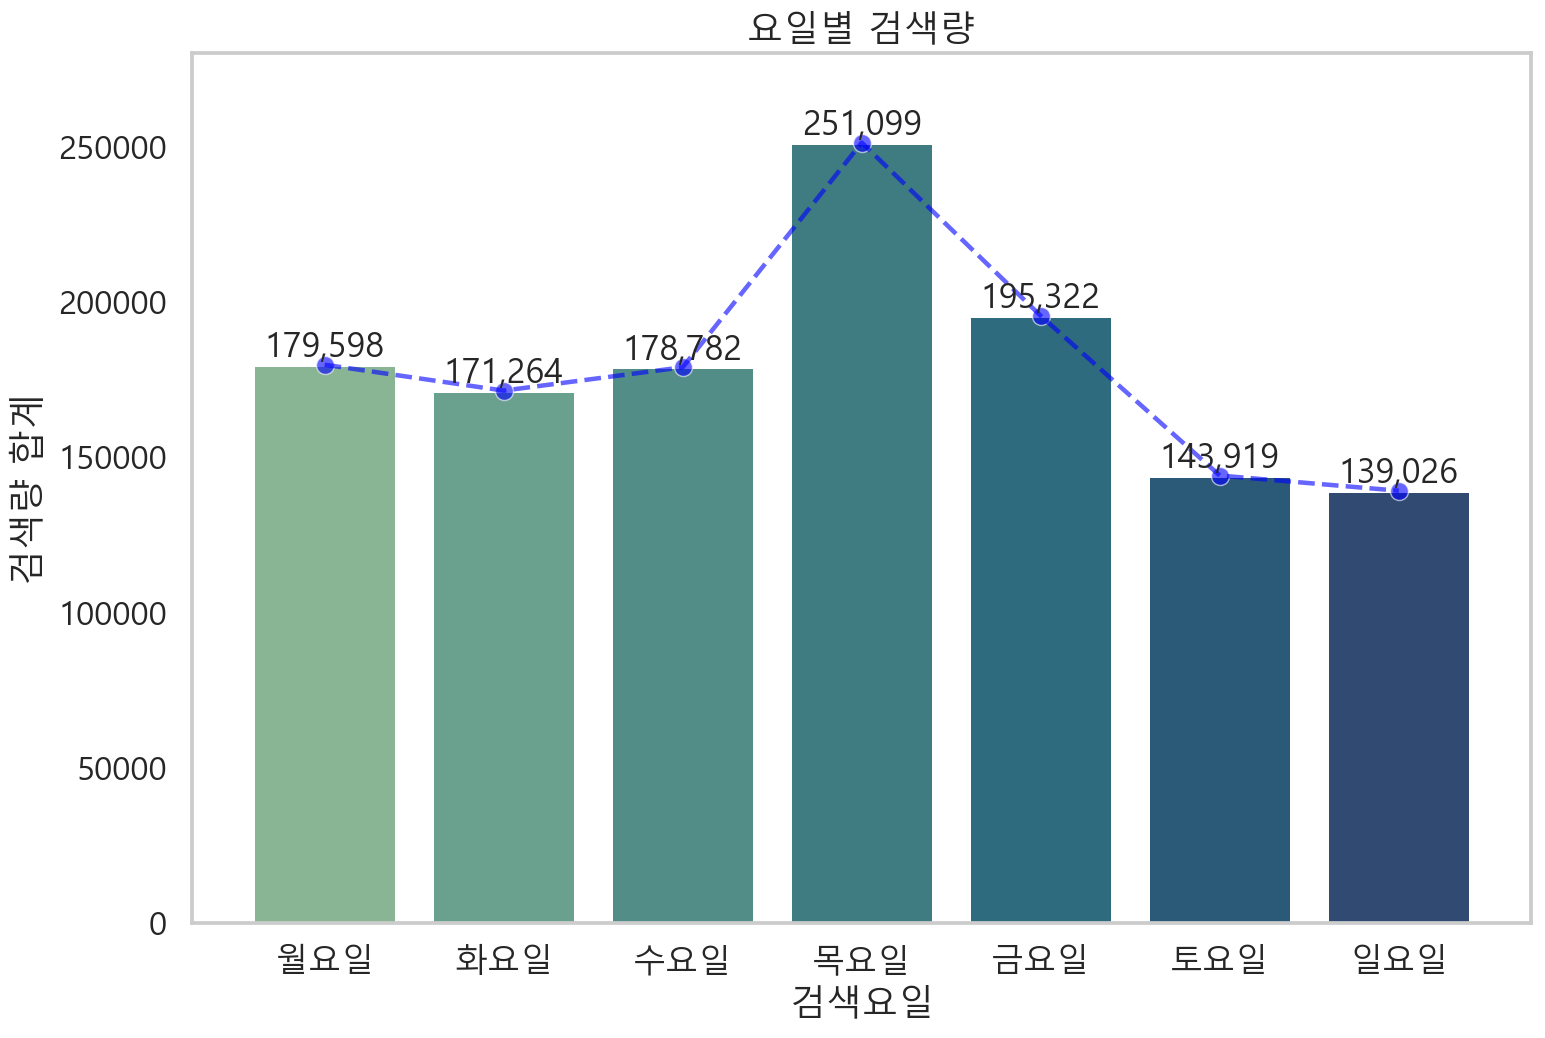

In [335]:
keyword_weekday = keyword_df.groupby('검색요일')[['검색량 합계']].sum().reindex(weekday_label)
plt.figure(figsize=(12,8))
sns.barplot(keyword_weekday.index, keyword_weekday['검색량 합계'], palette = 'crest')
sns.lineplot(keyword_weekday.index, keyword_weekday['검색량 합계'], color='b', linestyle='--',alpha=0.6)
sns.scatterplot(keyword_weekday.index, keyword_weekday['검색량 합계'], color='b', alpha=0.6)
plt.title('요일별 검색량')
for i,bar in enumerate(keyword_weekday['검색량 합계']):
    plt.text(weekday_label[i],bar,'{:,d}'.format(bar),ha='center',va='bottom',size=17)
plt.ylim(0,280000)
plt.grid(False)
plt.show()

In [296]:
keyword_weekday['검색량 합계']

검색요일
월요일    179598
화요일    171264
수요일    178782
목요일    251099
금요일    195322
토요일    143919
일요일    139026
Name: 검색량 합계, dtype: int64

[84114, 1174896]


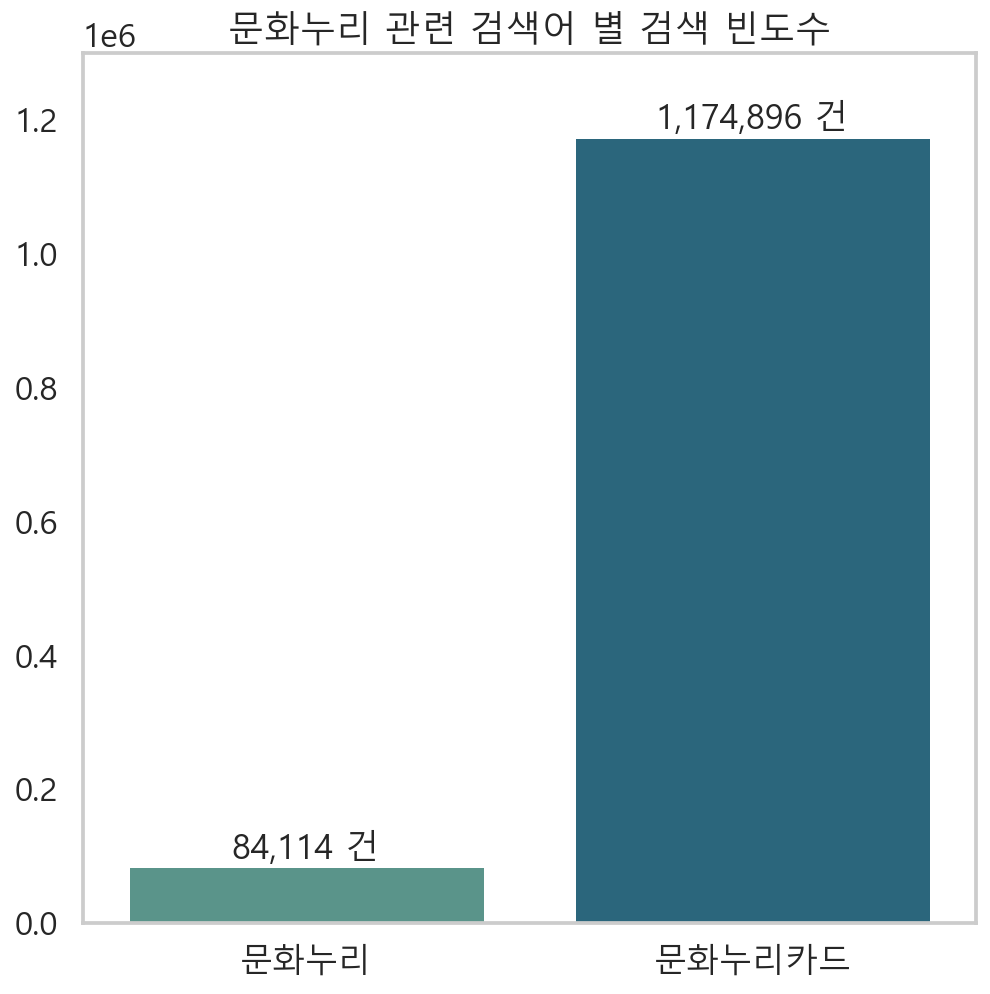

In [339]:
plt.figure(figsize=(8,8))
sns.barplot(['문화누리','문화누리카드'],[np.sum(key_a['검색량 합계']),np.sum(key_b['검색량 합계'])], palette = 'crest',ci=None)
print([np.sum(key_a['검색량 합계']),np.sum(key_b['검색량 합계'])])
plt.title('문화누리 관련 검색어 별 검색 빈도수')

for i,bar in enumerate([np.sum(key_a['검색량 합계']),np.sum(key_b['검색량 합계'])]):
    plt.text(i,bar,'{:,d} 건'.format(bar),ha='center',va='bottom',size=17)

plt.ylim(0,1300000)
plt.grid(False)
plt.show()

[문화누리 키워드 검색량 데이터 분석 결과]   
- 매채별로 키워드 검색량을 분석한 결과, Mobile기기를 활용한 검색량이 PC를 통한 검색량 보다 훨씬 많은 것을 알 수 있었다. 이는 문화누리카드 관련 정보에 대한 주 매개체가 Mobile 기기라는 것을 의미한다.   
- 문화누리 관련 키워드 검색량의 전체 추이를 분석한 결과, 2022 01월 초와 2022년 2월 초에 검색량이 급격히 많아지는 것을 볼 수 있었다. 하지만, 모두 일시적인 상승일 뿐 이내 다시 평균 추이로 돌아오는 것을 볼 수 있다.   
- 요일별 검색량을 확인해보니, 목요일에 유의미하게 가장 많은 검색량이 몰리는 것을 볼 수 있었다. 이는, 주말 전에 문화누리카드의 사용처나 관련 혜택 등을 검색하는 것으로 볼 수도 있고, 혹은 다른 외부 요인이 있을 것으로 보인다.   
- 문화누리 관련 키워드는 크게 '문화누리', '문화누리카드' 두 가지로 구분된다. 하지만, '문화누리카드'에 대한 검색량이 월등히 많으며 이는 문화누리카드의 발급조건, 사용처, 한도금액 등 실리적인 혜택에 대해 검색량이 몰리는 것으로 볼 수 있다.

## 2. 차상위계층 카드 가맹점 정보
[출처] : 한국문화예술위원회   

[Data Description]
- 부산지역 취약계층 가맹점 데이터   
- 기초생활 수급자/차상위 계층이 활용할 수 있는 문화누리카드 가맹점   

[Applications]
- 제공 가맹점 대상지역 차상위 계층의 카드 사용 활성화   
- 지원 카드 사용율과 제공 분야 개선

[Insight Goal]
- 제공 가맹점 매핑 및 접근성 분석

### Data Load

In [363]:
# Data Load
card_shop_df = pd.read_csv('data/ak_lwicc_card_mrhst_info_202103.csv')
card_shop_df.columns=return_col('차상위계층 카드 가맹점 정보_컬럼정의서.xls')
print('card_shop_df.shape :',card_shop_df.shape)
card_shop_df.head(2)

card_shop_df.shape : (5027, 12)


,일련번호,가맹점명,가맹점위도,가맹점경도,가맹점시도코드,가맹점시도명,가맹점시군구코드,가맹점시군구명,가맹점행정동코드,가맹점행정동명,가맹점구분코드,가맹점구분코드명
0,14,GS25 R부산동구2점,35.136637,129.065045,21,부산광역시,21030,동구,2103071,범일1동,B,급식카드가맹점
1,15,GS25 R부산동구3점,35.136637,129.065045,21,부산광역시,21030,동구,2103071,범일1동,B,급식카드가맹점


### Data EDA & Preprocessing

In [364]:
card_shop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5027 entries, 0 to 5026
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일련번호      5027 non-null   int64  
 1   가맹점명      5027 non-null   object 
 2   가맹점위도     5027 non-null   float64
 3   가맹점경도     5027 non-null   float64
 4   가맹점시도코드   5027 non-null   int64  
 5   가맹점시도명    5027 non-null   object 
 6   가맹점시군구코드  5027 non-null   int64  
 7   가맹점시군구명   5027 non-null   object 
 8   가맹점행정동코드  5027 non-null   int64  
 9   가맹점행정동명   5027 non-null   object 
 10  가맹점구분코드   5027 non-null   object 
 11  가맹점구분코드명  5027 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 471.4+ KB


In [365]:
# 급식카드가맹점 : B | 문화누리가맹점 : M
card_shop_df['가맹점구분코드'].value_counts()

B    3772
M    1255
Name: 가맹점구분코드, dtype: int64

In [366]:
# Feature Selection
card_shop_df.drop(['일련번호'],axis=1,inplace=True)
card_shop_df = card_shop_df[card_shop_df['가맹점구분코드명'] == '문화누리가맹점'].reset_index()
print('card_shop_df.shape :',card_shop_df.shape)
card_shop_df.head(2)

card_shop_df.shape : (1255, 12)


,index,가맹점명,가맹점위도,가맹점경도,가맹점시도코드,가맹점시도명,가맹점시군구코드,가맹점시군구명,가맹점행정동코드,가맹점행정동명,가맹점구분코드,가맹점구분코드명
0,469,삼천리자전거동래점,35.202679,129.083916,21,부산광역시,21060,동래구,2106051,수민동,M,문화누리가맹점
1,521,행복한스튜디오,35.152427,129.054766,21,부산광역시,21050,부산진구,2105052,부전2동,M,문화누리가맹점


In [368]:
# Subset for Mapping
map_subset = card_shop_df[['가맹점명','가맹점위도','가맹점경도']]
map_subset.columns = ['가맹점명','위도','경도']
print('map_subset :',map_subset.shape)
map_subset.head()

map_subset : (1255, 3)


,가맹점명,위도,경도
0,삼천리자전거동래점,35.202679,129.083916
1,행복한스튜디오,35.152427,129.054766
2,네이쳐앤트리,35.061973,128.984193
3,신평태권도장,35.093446,128.973558
4,송무인 신금 태권도,35.252920,129.013612


### Insight Inference & Visualization

In [387]:
# 부산지역 문화누리가맹점 지도 매핑
busan_coord = [35.1796,129.0756]
m = folium.Map(
    location = busan_coord,
    zoom_start=15)

for i in range(map_subset.shape[0]):
    folium.Marker([map_subset.iloc[i,1],map_subset.iloc[i,2]],
                 tooltip = map_subset.iloc[i,0],
                 icon=folium.Icon('blue',icon='star')).add_to(m)
m

In [388]:
# Map Figure Save
m.save('figure/Busan_Shop_map.html')

[차상위계층 카드 가맹점 정보 분석 결과]
- 부산지역 내 문화누리가맹점의 분포를 확인해보았다. 생각보다, 문화누리가맹점 수가 많은 것을 알 수 있었고 접근성 면에서는 크게 문제되지 않을 것으로 예상된다. 즉, 누구나 원한다면 카드를 사용할 수 있는 인프라는 만들어져있는 상태이고, 혜택과 홍보면에서 개선점을 가져간다면 충분히 활성화 가능성이 있다.